In [1]:

import sys
import pandas as pd
import datetime
import requests
import json
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_data(devid, acc_token, address, start_time, end_time):
    df=pd.DataFrame([])
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    if r2:
        
        # read all descriptors at once
        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [desc]
            df = pd.concat([df,df1], axis = 1)
                   

        if df.empty == False:
        
            df.reset_index(drop=False, inplace=True)
            df['ts'] = pd.to_datetime(df['ts'], unit='ms')
            # df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn).dt.tz_localize(None)
    
            # Set timestamp as index, convert all columns to float
            df = df.sort_values(by=['ts'])
            #df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn)
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts',inplace = True, drop = True)
            for col in df.columns:
                df[col] = df[col].astype('float')
    return df

In [3]:
did ={'102.104.000220':'2e092150-07a5-11ea-a66e-7bc859fa1c1b','102.201.000662':'c1ca6800-07a4-11ea-a66e-7bc859fa1c1b','102.201.000665':'080958d0-07a5-11ea-a66e-7bc859fa1c1b'}

In [43]:
devid = did['102.201.000665'] 
start_time = '1594023600000' # 6th of July 12:00 am utc
end_time = '1611223200000' # 21th of January 


#address = "http://157.230.210.37:8081"
address = "https://m3.zeb.gr"


r = requests.post(address + "/api/auth/login",json={'username': 'a.papagiannaki@meazon.com', 'password': 'eurobank'}).json()


# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']

df = read_data(devid, acc_token, address, start_time, end_time)


In [44]:
df = df.iloc[:-3]
df.tail()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC
ts,,,,,,
2021-01-21 09:39:19,362.968,538.297,438.735,NaN,NaN,NaN
2021-01-21 09:42:46,359.522,504.452,392.312,NaN,NaN,NaN
2021-01-21 09:44:20,368.838,492.737,409.751,NaN,NaN,NaN
2021-01-21 09:49:20,418.727,644.638,437.990,NaN,NaN,NaN
2021-01-21 09:50:55,NaN,NaN,NaN,4479413.0,5231976.0,4670275.0


In [45]:
df = df.groupby(df.index).max()

df.index = df.index.ceil('5T')
df =  df .resample('5T').max()
df.tail()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC
ts,,,,,,
2021-01-21 09:35:00,363.608,539.018,437.865,NaN,NaN,NaN
2021-01-21 09:40:00,362.968,538.297,438.735,NaN,NaN,NaN
2021-01-21 09:45:00,368.838,504.452,409.751,NaN,NaN,NaN
2021-01-21 09:50:00,418.727,644.638,437.990,NaN,NaN,NaN
2021-01-21 09:55:00,NaN,NaN,NaN,4479413.0,5231976.0,4670275.0


In [46]:
df['pwrA'].iloc[-1] = df['pwrA'].iloc[-2]
df['pwrB'].iloc[-1] = df['pwrB'].iloc[-2]
df['pwrC'].iloc[-1] = df['pwrC'].iloc[-2]
df.tail()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC
ts,,,,,,
2021-01-21 09:35:00,363.608,539.018,437.865,NaN,NaN,NaN
2021-01-21 09:40:00,362.968,538.297,438.735,NaN,NaN,NaN
2021-01-21 09:45:00,368.838,504.452,409.751,NaN,NaN,NaN
2021-01-21 09:50:00,418.727,644.638,437.990,NaN,NaN,NaN
2021-01-21 09:55:00,418.727,644.638,437.990,4479413.0,5231976.0,4670275.0


In [47]:
# df =  df .resample('5T').max()
df = df[df['pwrA'].notna()]
df = df[df['pwrB'].notna()]
df = df[df['pwrC'].notna()]

for pwr in ['pwrA','pwrB','pwrC']:
    while len(df.loc[df[pwr]<0,pwr])>0:
        df.loc[df[pwr]<0, pwr] = df[pwr].shift()

df['delta'] = np.nan
for i in range(1,df.shape[0]):
    df['delta'] = (df.index[i] - df.index[i-1]).total_seconds()

df.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta
ts,,,,,,,
2020-07-06 08:25:00,450.190,1065.946,464.422,3352346.0,3792315.0,3614943.0,300.0
2020-07-06 08:30:00,455.113,669.672,460.859,3352384.0,3792375.0,3614981.0,300.0
2020-07-06 08:35:00,457.543,627.621,461.460,3352421.0,3792429.0,3615020.0,300.0
2020-07-06 08:40:00,1851.926,634.609,482.359,3352480.0,3792483.0,3615060.0,300.0
2020-07-06 08:45:00,459.667,726.670,497.912,3352562.0,3792537.0,3615100.0,300.0


In [48]:
df = df.iloc[7:]
df.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta
ts,,,,,,,
2020-07-06 09:00:00,464.500,638.839,495.492,3352674.0,3792709.0,3615229.0,300.0
2020-07-06 09:05:00,447.887,636.436,488.113,NaN,NaN,NaN,300.0
2020-07-06 09:10:00,462.035,635.502,484.232,NaN,NaN,NaN,300.0
2020-07-06 09:20:00,446.462,821.997,482.673,NaN,NaN,NaN,300.0
2020-07-06 09:25:00,427.275,713.502,483.890,NaN,NaN,NaN,300.0


In [49]:
for pwr in ['pwrA','pwrB','pwrC']:
    df[pwr+'nrg'] = (df[pwr]*df['delta'])/3600
df.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg
ts,,,,,,,,,,
2020-07-06 09:00:00,464.500,638.839,495.492,3352674.0,3792709.0,3615229.0,300.0,38.708333,53.236583,41.291000
2020-07-06 09:05:00,447.887,636.436,488.113,NaN,NaN,NaN,300.0,37.323917,53.036333,40.676083
2020-07-06 09:10:00,462.035,635.502,484.232,NaN,NaN,NaN,300.0,38.502917,52.958500,40.352667
2020-07-06 09:20:00,446.462,821.997,482.673,NaN,NaN,NaN,300.0,37.205167,68.499750,40.222750
2020-07-06 09:25:00,427.275,713.502,483.890,NaN,NaN,NaN,300.0,35.606250,59.458500,40.324167


In [50]:
totalnrgA = df['cnrgA'].iloc[-1] - df['cnrgA'].iloc[0]
totalnrgB = df['cnrgB'].iloc[-1] - df['cnrgB'].iloc[0]
totalnrgC = df['cnrgC'].iloc[-1] - df['cnrgC'].iloc[0]
print(totalnrgA,totalnrgB,totalnrgC)

1126739.0 1439267.0 1055046.0


In [51]:
pnrgA = np.sum(df['pwrAnrg'].iloc[1:-1])
pnrgB = np.sum(df['pwrBnrg'].iloc[1:-1])
pnrgC = np.sum(df['pwrCnrg'].iloc[1:-1])
print(pnrgA,pnrgB,pnrgC)

difA = totalnrgA - pnrgA
difB = totalnrgB - pnrgB
difC = totalnrgC - pnrgC
print(difA,difB,difC)

1125265.7545833334 1434250.6769166666 1051624.0835833333
1473.245416666614 5016.323083333438 3421.9164166667033


In [52]:
import math
offsetA = math.floor(difA/(df.shape[0]-2)*100)/100
offsetB = math.floor(difB/(df.shape[0]-2)*100)/100
offsetC = math.floor(difC/(df.shape[0]-2)*100)/100
print(offsetA,offsetB,offsetC)

df['pwrAnrg'] = df['pwrAnrg']+offsetA-0.01
df['pwrBnrg'] = df['pwrBnrg']+offsetB
df['pwrCnrg'] = df['pwrCnrg']+offsetC-0.01

df.head()

0.02 0.08 0.05


,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg
ts,,,,,,,,,,
2020-07-06 09:00:00,464.500,638.839,495.492,3352674.0,3792709.0,3615229.0,300.0,38.718333,53.316583,41.341000
2020-07-06 09:05:00,447.887,636.436,488.113,NaN,NaN,NaN,300.0,37.333917,53.116333,40.726083
2020-07-06 09:10:00,462.035,635.502,484.232,NaN,NaN,NaN,300.0,38.512917,53.038500,40.402667
2020-07-06 09:20:00,446.462,821.997,482.673,NaN,NaN,NaN,300.0,37.215167,68.579750,40.272750
2020-07-06 09:25:00,427.275,713.502,483.890,NaN,NaN,NaN,300.0,35.616250,59.538500,40.374167


In [53]:
for pwr in ['pwrA','pwrB','pwrC']:    
    df[pwr+'nrg'] = df[pwr+'nrg'].round().astype(int)
    


In [56]:
pnrgA = np.sum(df['pwrAnrg'].iloc[1:-1])
pnrgB = np.sum(df['pwrBnrg'].iloc[1:-1])
pnrgC = np.sum(df['pwrCnrg'].iloc[1:-1])
print(pnrgA,pnrgB,pnrgC)

difA = totalnrgA - pnrgA
difB = totalnrgB - pnrgB
difC = totalnrgC - pnrgC
print(difA,difB,difC)

1126613 1439136 1054915.4900000002
126.0 131.0 130.50999999977648


In [57]:
for i in range(1,df.shape[0]-1):
    if (i)%int(1+df.iloc[1:-1].shape[0]/difA)==0:
        df['pwrAnrg'].iloc[i] = df['pwrAnrg'].iloc[i]+1
    if (i)%int(2+df.iloc[1:-1].shape[0]/difB)==0:
        df['pwrBnrg'].iloc[i] = df['pwrBnrg'].iloc[i]+1
    if (i)%int(1+df.iloc[1:-1].shape[0]/difC)==0:
        df['pwrCnrg'].iloc[i] = df['pwrCnrg'].iloc[i]+1

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [58]:
pnrgA = np.sum(df['pwrAnrg'].iloc[1:-1])
pnrgB = np.sum(df['pwrBnrg'].iloc[1:-1])
pnrgC = np.sum(df['pwrCnrg'].iloc[1:-1])
print(pnrgA,pnrgB,pnrgC)

difA = totalnrgA - pnrgA
difB = totalnrgB - pnrgB
difC = totalnrgC - pnrgC
print(difA,difB,difC)

1126738 1439266 1055045.4900000002
1.0 1.0 0.5099999997764826


In [59]:
df.tail()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg
ts,,,,,,,,,,
2021-01-21 09:35:00,363.608,539.018,437.865,NaN,NaN,NaN,300.0,30,45,36.99
2021-01-21 09:40:00,362.968,538.297,438.735,NaN,NaN,NaN,300.0,30,45,36.99
2021-01-21 09:45:00,368.838,504.452,409.751,NaN,NaN,NaN,300.0,31,42,33.99
2021-01-21 09:50:00,418.727,644.638,437.990,NaN,NaN,NaN,300.0,35,54,36.99
2021-01-21 09:55:00,418.727,644.638,437.990,4479413.0,5231976.0,4670275.0,300.0,35,54,36.99


In [60]:
tmp = df.copy()
for i in range(1,(df.shape[0]-1)):
    tmp['cnrgA'].iloc[i] = tmp['cnrgA'].iloc[i-1]+tmp['pwrAnrg'].iloc[i]
    tmp['cnrgB'].iloc[i] = tmp['cnrgB'].iloc[i-1]+tmp['pwrBnrg'].iloc[i]
    tmp['cnrgC'].iloc[i] = tmp['cnrgC'].iloc[i-1]+tmp['pwrCnrg'].iloc[i]

/home/emilyp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [61]:
tmp['nrgA'] = tmp['cnrgA'] - tmp['cnrgA'].shift()
tmp['nrgB'] = tmp['cnrgB'] - tmp['cnrgB'].shift()
tmp['nrgC'] = tmp['cnrgC'] - tmp['cnrgC'].shift()
tmp.head()

,pwrA,pwrB,pwrC,cnrgA,cnrgB,cnrgC,delta,pwrAnrg,pwrBnrg,pwrCnrg,nrgA,nrgB,nrgC
ts,,,,,,,,,,,,,
2020-07-06 09:00:00,464.500,638.839,495.492,3352674.0,3792709.0,3615229.00,300.0,39,53,40.99,NaN,NaN,NaN
2020-07-06 09:05:00,447.887,636.436,488.113,3352711.0,3792762.0,3615269.99,300.0,37,53,40.99,37.0,53.0,40.99
2020-07-06 09:10:00,462.035,635.502,484.232,3352750.0,3792815.0,3615309.98,300.0,39,53,39.99,39.0,53.0,39.99
2020-07-06 09:20:00,446.462,821.997,482.673,3352787.0,3792884.0,3615349.97,300.0,37,69,39.99,37.0,69.0,39.99
2020-07-06 09:25:00,427.275,713.502,483.890,3352823.0,3792944.0,3615389.96,300.0,36,60,39.99,36.0,60.0,39.99


In [69]:
for nrg in ['cnrgA','cnrgB','cnrgC']:
    tmp[nrg] = tmp[nrg].astype(int)

In [70]:
tmp = tmp.iloc[1:]
tmp = tmp.iloc[:-1]


In [71]:
tmp = tmp[['cnrgA','cnrgB','cnrgC']]

In [72]:
tmp['cnrgA'] = tmp['cnrgA'].apply(str)
tmp['cnrgB'] = tmp['cnrgB'].apply(str)
tmp['cnrgC'] = tmp['cnrgC'].apply(str)
tmp['ts'] = tmp.index.values.astype(np.int64) // 10 ** 6
tmp['ts'] = tmp['ts'].astype(int)
tmp.set_index('ts',inplace = True, drop = True)
nrgdict = tmp.to_dict('index')
nrgdict

{1594026300000: {'cnrgA': '3352711', 'cnrgB': '3792762', 'cnrgC': '3615269'},
 1594026600000: {'cnrgA': '3352750', 'cnrgB': '3792815', 'cnrgC': '3615309'},
 1594027200000: {'cnrgA': '3352787', 'cnrgB': '3792884', 'cnrgC': '3615349'},
 1594027500000: {'cnrgA': '3352823', 'cnrgB': '3792944', 'cnrgC': '3615389'},
 1594027800000: {'cnrgA': '3353088', 'cnrgB': '3792995', 'cnrgC': '3615428'},
 1594028100000: {'cnrgA': '3353130', 'cnrgB': '3793047', 'cnrgC': '3615468'},
 1594028400000: {'cnrgA': '3353171', 'cnrgB': '3793111', 'cnrgC': '3615509'},
 1594028700000: {'cnrgA': '3353212', 'cnrgB': '3793163', 'cnrgC': '3615549'},
 1594029000000: {'cnrgA': '3353253', 'cnrgB': '3793216', 'cnrgC': '3615588'},
 1594029300000: {'cnrgA': '3353296', 'cnrgB': '3793266', 'cnrgC': '3615826'},
 1594029600000: {'cnrgA': '3353340', 'cnrgB': '3793318', 'cnrgC': '3615866'},
 1594029900000: {'cnrgA': '3353383', 'cnrgB': '3793364', 'cnrgC': '3615906'},
 1594030200000: {'cnrgA': '3353426', 'cnrgB': '3793410', 'cnrgC'

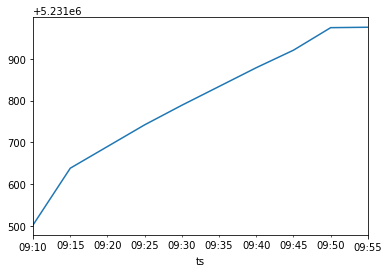

In [68]:
tmp['cnrgB'].iloc[-10:].plot()

In [73]:
tmp.to_csv('665.csv')
